<a href="https://colab.research.google.com/github/junjunmeng/Python-/blob/master/Funnel_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
cd '/content/drive/My Drive/01-Funnel analysis'

/content/drive/My Drive/01-Funnel analysis


In [0]:
import pandas as pd
import numpy as np


In [0]:
home_page = pd.read_csv('home_page_table.csv')
confirmation = pd.read_csv('payment_confirmation_table.csv')
payment_page = pd.read_csv('payment_page_table.csv')
search_page = pd.read_csv('search_page_table.csv')
user = pd.read_csv('user_table.csv')

In [0]:
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [0]:
data = user.merge(home_page, how = 'left', on = 'user_id').merge(search_page, how = 'left', on = 'user_id').merge(payment_page, how = 'left', on = 'user_id').merge(confirmation, how = 'left', on = 'user_id')

In [0]:
data.columns=['user_id', 'date', 'device', 'sex', 'home','search','payment', 'confirmation']

#  <font color = 'blue'> 1. Calculate and visualize conversion rate 

In [0]:
conv_ratio = 1-pd.DataFrame(data.isnull().sum()).rename(columns = {0:"conversion"})/len(data)
conv_ratio.reset_index()[4:]

,index,conversion
4,home,1.000000
5,search,0.500000
6,payment,0.066704
7,confirmation,0.005000


In [0]:
data.home.value_counts()

home_page    90400
Name: home, dtype: int64

In [0]:
data.head()

,user_id,date,device,sex,home,search,payment,confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [0]:
def conversion_rate(df):
  rates = {}
  rates['search'] = df['search'].count()/df['home'].count()
  rates['payment'] = df['payment'].count()/df['search'].count()
  rates['confirmation'] = df['confirmation'].count()/df['payment'].count()
  return rates

rate = conversion_rate(data)

rate_report = pd.DataFrame.from_dict(rate, orient='index').reset_index()
rate_report.columns=['page', 'conversion_rate']

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

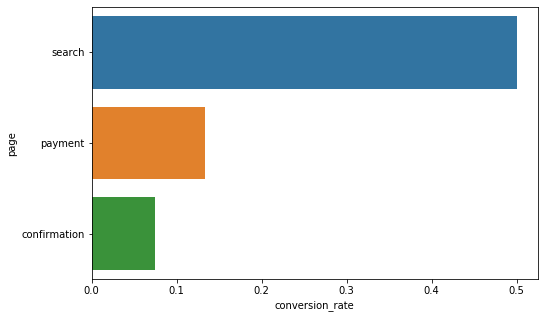

In [0]:
fig, ax = plt.subplots(figsize = (8,5))
g = sns.barplot(x= 'conversion_rate', y = 'page', data = rate_report, ax = ax)



# <font color = 'blue'> 2. Effect of device, sex and date

### <font color ='blue'> 2.1 The effect of Device

In [0]:
# the converison rate from Desktop

Desktop = pd.DataFrame.from_dict(conversion_rate(data[data.device == 'Desktop']), orient='index').reset_index()
Desktop.columns = ['page', 'Desktop_conversion']
Desktop

,page,Desktop_conversion
0,search,0.500000
1,payment,0.100000
2,confirmation,0.049834


In [0]:
# conversion rate from mobile

mobile = pd.DataFrame.from_dict(conversion_rate(data[data.device == 'Mobile']), orient='index').reset_index()
mobile.columns = ['page', 'mobile_conversion']
mobile

,page,mobile_conversion
0,search,0.5
1,payment,0.2
2,confirmation,0.1


In [0]:
# out join two tables

df=pd.merge(mobile, Desktop, how = 'outer', on = 'page' )

In [0]:
# table reshape for visualization 

device = pd.melt(df, id_vars= ['page'], var_name= 'device', value_name='conversion_rate')

print (device)

           page              device  conversion_rate
0        search   mobile_conversion         0.500000
1       payment   mobile_conversion         0.200000
2  confirmation   mobile_conversion         0.100000
3        search  Desktop_conversion         0.500000
4       payment  Desktop_conversion         0.100000
5  confirmation  Desktop_conversion         0.049834


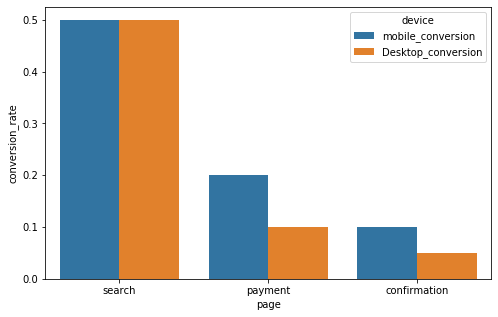

In [0]:
# visulize the conversion rate at different devices

fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = 'page', y = 'conversion_rate', data = device, ax = ax, hue= 'device')
plt.show()

### <font color = 'blue'> 2.2 The Effect of Date

In [0]:
# change date to date format and get day of week by dt.weekday_name

data['date']= pd.to_datetime(data['date'])

data['day_of_week'] = data['date'].dt.weekday_name

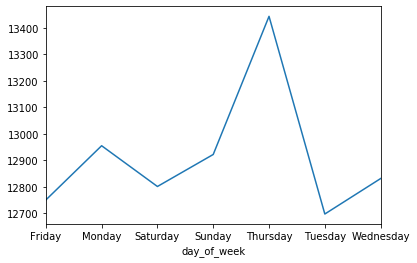

In [0]:
import numpy as np

data.groupby('day_of_week')['home', 'search', 'payment', 'confirmation'].size().plot()

In [0]:
data['home']= data['home'].apply(lambda x : 0 if pd.isnull(x) else 1)
data['search']= data['search'].apply(lambda x : 0 if pd.isnull(x) else 1)
data['payment']= data['payment'].apply(lambda x : 0 if pd.isnull(x) else 1)
data['confirmation']= data['confirmation'].apply(lambda x : 0 if pd.isnull(x) else 1)

In [0]:
# funnel analysis by day of week

Day_week = data.groupby('day_of_week')['home', 'search','payment','confirmation' ].agg(np.sum).reset_index()


In [0]:
Day_week.head()

,day_of_week,home,search,payment,confirmation
0,Friday,12750,6406,871,54
1,Monday,12955,6483,869,77
2,Saturday,12801,6545,845,70
3,Sunday,12922,6462,855,62
4,Thursday,13444,6717,899,66


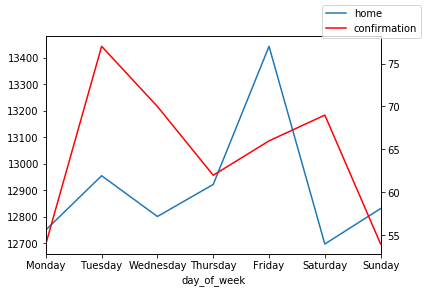

In [0]:
# comparing home and confirmation by day_of_week using dual axis

ax = Day_week.plot(x= 'day_of_week', y = 'home', legend = False)
ax2 = ax.twinx()
Day_week.plot(x = 'day_of_week', y = 'confirmation', legend = False, ax = ax2, color = 'r' )
ax.figure.legend()


weekday_names = ['Monday', 'Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
ax.set_xticklabels(weekday_names)

plt.show()

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [0]:
week_sex = data.groupby(['day_of_week', 'sex'  ])['home', 'search','payment','confirmation' ].agg(np.sum).reset_index()

week_sex['confirmation/home'] = round(100 * week_sex['confirmation']/week_sex['home'],2)

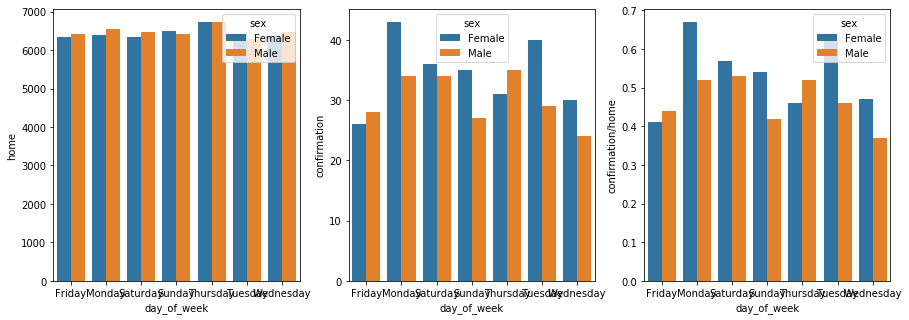

In [0]:

fig2 = plt.figure(constrained_layout = False, figsize= (15,5))
spec2 = gridspec.GridSpec(ncols=3, nrows = 1, figure = fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
sns.barplot(data=week_sex, x = 'day_of_week', y = 'confirmation', hue = 'sex', ax= f2_ax2)
sns.barplot(data=week_sex, x = 'day_of_week', y = 'home', hue = 'sex', ax = f2_ax1)
sns.barplot(data=week_sex, x = 'day_of_week', y = 'confirmation/home', hue = 'sex', ax = f2_ax3)

In [0]:
week_device = data.groupby(['day_of_week', 'device'  ])['home', 'search','payment','confirmation' ].agg(np.sum).reset_index()
week_device['confirmation/home'] = round(100* week_device['confirmation']/week_device['home'],2) 

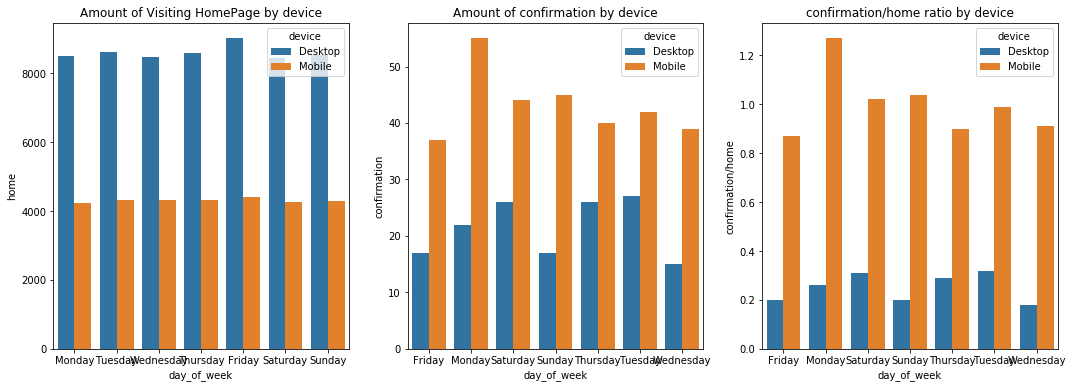

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig3 = plt.figure(constrained_layout = False, figsize= (18,6))
spec3 = gridspec.GridSpec(ncols=3, nrows = 1, figure = fig3)
f3_ax1 = fig3.add_subplot(spec3[0, 0])
f3_ax2 = fig3.add_subplot(spec3[0, 1])
f3_ax3 = fig3.add_subplot(spec3[0, 2])

sns.barplot(data=week_device, x = 'day_of_week', y = 'confirmation', hue = 'device', ax= f3_ax2)
sns.barplot(data=week_device, x = 'day_of_week', y = 'home', hue = 'device', ax = f3_ax1)
sns.barplot(data=week_device, x = 'day_of_week', y = 'confirmation/home', hue = 'device', ax = f3_ax3)
f3_ax1.set_title("Amount of Visiting HomePage by device")
f3_ax2.set_title("Amount of confirmation by device")
f3_ax3.set_title("confirmation/home ratio by device")

weekday_names = ['Monday', 'Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']

f3_ax1.set_xticklabels(weekday_names)
f3_ax1.set_xticks(range(0, len(weekday_names)))
plt.show()

### <font color = 'blue'> 2.3 contribution of Sex/Device combination

In [0]:
# contribution of sex/device combination

device_sex = data.groupby(['device', 'sex'])['confirmation'].agg(np.sum).reset_index()
device_sex['contribution'] = round(device_sex['confirmation']*100/device_sex['confirmation'].sum(),2 )

device_sex

,device,sex,confirmation,contribution
0,Desktop,Female,74,16.37
1,Desktop,Male,76,16.81
2,Mobile,Female,167,36.95
3,Mobile,Male,135,29.87
